In [1]:
# Python 3.8.10 64-bit
# Local Jupyter Notebook in VS Code

# Install requirements as listed in pyweka documentation.
# http://fracpete.github.io/python-weka-wrapper3/install.html#windows

# Oracle JDK required.
# https://www.oracle.com/java/technologies/downloads/#jdk17-windows

Install packages and libraries

In [1]:
#%pip install numpy-1.21.5+vanilla-cp38-cp38-win_amd64.whl
#%pip install javabridge-1.0.19-cp38-cp38-win_amd64.whl
#%pip install matplotlib-3.5.1-cp38-cp38-win_amd64.whl

In [2]:
#%pip install python-weka-wrapper3
#%pip install plotly

In [3]:
# install zeek analysis tool package
# https://github.com/SuperCowPowers/zat/tree/master/zat

#%pip install zat

In [4]:
# Install python packages typically used with weka. Add / Remove items as needed.

import os
import zat
import glob
import tempfile
import itertools
import traceback
import numpy as np
import pandas as pd
import weka.core.jvm as jvm
import matplotlib.pyplot as plt
import weka.plot.classifiers as plot_cls
import plotly.graph_objects as go
import weka.plot.graph as graph
import weka.plot.graph as plot_graph
import weka.core.typeconv as typeconv
import weka.core.converters as converters
import plotly.graph_objects as go
import weka.plot.classifiers as plcls

from weka.filters import Filter
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
from weka.core.classes import from_commandline
from weka.core.classes import to_commandline
from weka.classifiers import Evaluation
from weka.core.classes import Random
from weka.filters import Filter
from weka.classifiers import Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random, from_commandline
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier
from weka.classifiers import PredictionOutput, Kernel, KernelClassifier
from weka.experiments import SimpleCrossValidationExperiment, SimpleRandomSplitExperiment, Tester, ResultMatrix

Load data from log file and create both dataframe and csv file

In [5]:
# Create a Pandas dataframe from network log using zat logtodataframe function 
# https://mcfp.felk.cvut.cz/publicDatasets/IoT-23-Dataset/IndividualScenarios/CTU-IoT-Malware-Capture-20-1/bro/

log_to_df = LogToDataFrame()
log_df = log_to_df.create_dataframe("conn.log.labeled")

# Print out the head of the dataframe
# log_df.head()

# Save dataframe to csv file

log_df.to_csv("testzat.csv")

In [6]:
log_df.describe()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,3209.000000,3209.000000,2324,2324.000000,2324.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000
mean,8939.868806,113.302586,0 days 00:00:37.898507848,72.502582,65.699225,2.387348,6.490807,310.303521,6.349018,291.973824
std,18604.179531,99.275039,0 days 00:20:58.145009362,556.850057,553.773292,88.679133,214.346608,9010.262223,224.835352,9432.739603
min,123.000000,22.000000,0 days 00:00:00.000480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,123.000000,123.000000,0 days 00:00:00.002744,48.000000,48.000000,0.000000,1.000000,76.000000,0.000000,0.000000
50%,123.000000,123.000000,0 days 00:00:00.005746,48.000000,48.000000,0.000000,1.000000,76.000000,1.000000,76.000000
75%,123.000000,123.000000,0 days 00:00:00.056341500,48.000000,48.000000,0.000000,1.000000,76.000000,1.000000,76.000000
max,60974.000000,5355.000000,0 days 12:18:45.615625,19431.000000,19431.000000,4500.000000,8872.000000,372893.000000,9307.000000,388975.000000


Start Java VM for algorithm library and load data

In [8]:
import weka.core.jvm as jvm
jvm.start(packages=True,max_heap_size="16g")

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


In [10]:
# Load csv file and filter empty columns # 13 and # 14

from weka.core.converters import Loader

csv_loader = Loader(classname="weka.core.converters.CSVLoader")
csv_data = csv_loader.load_file("testzat.csv")
csv_data.class_is_last()

csv_remove = Filter(classname="weka.filters.unsupervised.attribute.Remove", options=["-R", "13,14"])
csv_remove.inputformat(csv_data)
dataset = csv_remove.filter(csv_data)


Decision Tree

In [11]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.trees.J48").to_help()) 

In [12]:
# Build and run decision tree model

DT = Classifier(classname="weka.classifiers.trees.J48", options=["-C", "0.3"])
DT.build_classifier(dataset)

DT_evl = Evaluation(dataset)
DT_evl.crossvalidate_model(DT, dataset, 10, Random(1))
print(DT_evl.matrix("=== Decision Tree (J48) ==="))
print(DT_evl.summary())
print(DT_evl.class_details())

=== Decision Tree (J48) ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3208               99.9688 %
Incorrectly Classified Instances         1                0.0312 %
Kappa statistic                          0.9695
Mean absolute error                      0.0006
Root mean squared error                  0.0182
Relative absolute error                  6.0355 %
Root relative squared error             25.8632 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      0.970    1.000     1.000     -   Benign   -
                 1.000    0.000    0.941      1.000    0.970      0.970    1.000     0.887     -   Malicious   C&C-Torii
Weighted Avg.    1.000    0.000    1.000      1.000    1.000   

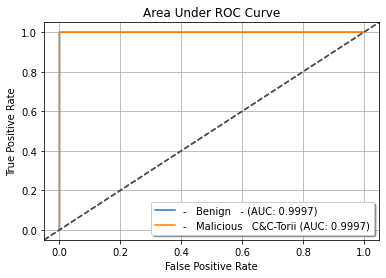

In [13]:
# Display ROC Curve

plcls.plot_roc(DT_evl, title="Area Under ROC Curve", class_index=[0, 1], wait=True)

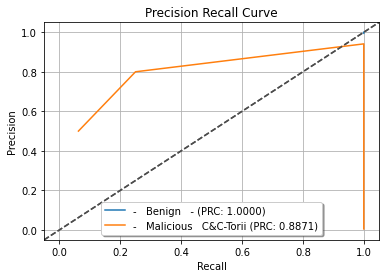

In [14]:
# Display Precision Recall Curve

plcls.plot_prc(DT_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Bayes Network

In [15]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.bayes.BayesNet").to_help()) 

In [17]:
# Build and run Bayesian Network classificaiton model with default options

Nbn_cls = Classifier(classname="weka.classifiers.bayes.BayesNet")
Nbn_cls.build_classifier(dataset)

Nbn_evl = Evaluation(dataset)
Nbn_evl.crossvalidate_model(Nbn_cls, dataset, 10, Random(1))

print(Nbn_evl.matrix("=== Bayes Network ==="))
print(Nbn_evl.summary())
print(Nbn_evl.class_details())

=== Bayes Network ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3207               99.9377 %
Incorrectly Classified Instances         2                0.0623 %
Kappa statistic                          0.9409
Mean absolute error                      0.0006
Root mean squared error                  0.0231
Relative absolute error                  5.6052 %
Root relative squared error             32.8204 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.999    0.000    1.000      0.999    1.000      0.943    1.000     1.000     -   Benign   -
                 1.000    0.001    0.889      1.000    0.941      0.943    1.000     1.000     -   Malicious   C&C-Torii
Weighted Avg.    0.999    0.000    0.999      0.999    0.999      0.9

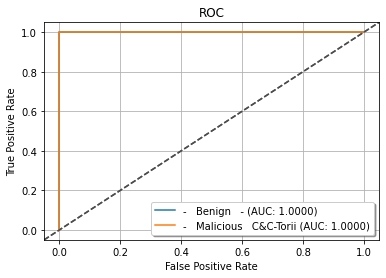

In [69]:
# Display ROC Curve

plcls.plot_roc(Nbn_evl, class_index=[0, 1], wait=True)

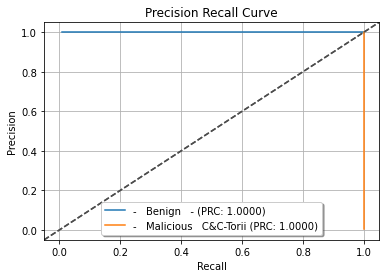

In [18]:
# Display Precision Recall Curve

plcls.plot_prc(Nbn_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

AdaBoost Bayes Network

In [19]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.meta.AdaBoostM1").to_help()) 

In [20]:
# Build and run Bayesian Network model with adaptive boosting ensemble algorithm

B_Nbn_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.bayes.BayesNet -- -D -Q weka.classifiers.bayes.net.search.local.K2 -- -P 1 -S BAYES -E weka.classifiers.bayes.net.estimate.SimpleEstimator -- -A 0.5'
B_Nbn_cls = from_commandline(B_Nbn_cmdline, classname="weka.classifiers.Classifier")
B_Nbn_cls.build_classifier(dataset)

B_Nbn_evl = Evaluation(dataset)
B_Nbn_evl.crossvalidate_model(B_Nbn_cls, dataset, 10, Random(1))
print(B_Nbn_evl.matrix("=== AdaBoost Bayes Network ==="))
print(B_Nbn_evl.summary())
print(B_Nbn_evl.class_details())

=== AdaBoost Bayes Network ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3207               99.9377 %
Incorrectly Classified Instances         2                0.0623 %
Kappa statistic                          0.9409
Mean absolute error                      0.0006
Root mean squared error                  0.0231
Relative absolute error                  5.6075 %
Root relative squared error             32.8204 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.999    0.000    1.000      0.999    1.000      0.943    1.000     1.000     -   Benign   -
                 1.000    0.001    0.889      1.000    0.941      0.943    1.000     1.000     -   Malicious   C&C-Torii
Weighted Avg.    0.999    0.000    0.999      0.999    0.999

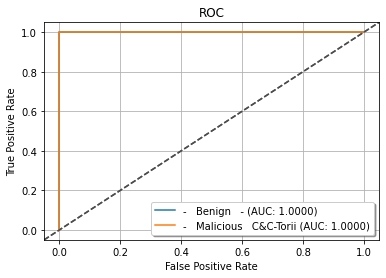

In [21]:
# Display ROC Curve

plcls.plot_roc(B_Nbn_evl, class_index=[0, 1], wait=True)

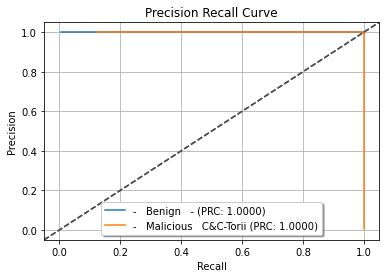

In [22]:
# Display Precision Recall Curve

plcls.plot_prc(B_Nbn_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

AdaBoost Decision Stump

In [23]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.trees.DecisionStump").to_help()) 

In [24]:
# Build and run Decision Stump model with adaptive boosting ensemble algorithm 

B_DS_cmdline = 'weka.classifiers.meta.AdaBoostM1 -P 100 -S 1 -I 10 -W weka.classifiers.trees.DecisionStump'
B_DS_cls = from_commandline(B_DS_cmdline, classname="weka.classifiers.Classifier")
B_DS_cls.build_classifier(dataset)

B_DS_evl = Evaluation(dataset)
B_DS_evl.crossvalidate_model(B_DS_cls, dataset, 10, Random(1))
print(B_DS_evl.matrix("=== AdaBoost Decision Stump ==="))
print(B_DS_evl.summary())
print(B_DS_evl.class_details())

=== AdaBoost Decision Stump ===
    a    b   <-- classified as
 3193    0 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3209              100      %
Incorrectly Classified Instances         0                0      %
Kappa statistic                          1     
Mean absolute error                      0     
Root mean squared error                  0     
Relative absolute error                  0      %
Root relative squared error              0      %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     -   Benign   -
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     -   Malicious   C&C-Torii
Weighted Avg.    1.000    0.000    1.000      1.000    1.00

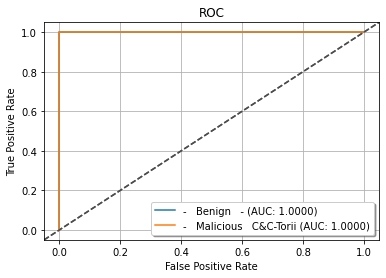

In [25]:
# Display ROC Curve

plcls.plot_roc(B_DS_evl, class_index=[0, 1], wait=True)

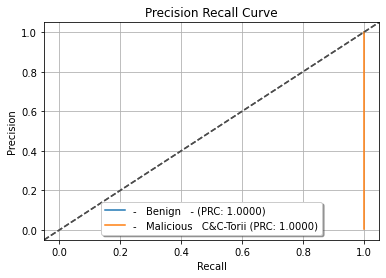

In [28]:
# Display Precision Recall Curve

plcls.plot_prc(B_DS_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Naive Bayes

In [29]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.bayes.NaiveBayes").to_help()) 

In [30]:
# Build and run Naive Bayes model

NB_cls = Classifier(classname="weka.classifiers.bayes.NaiveBayes")
NB_cls.build_classifier(dataset)

NB_evl = Evaluation(dataset)
NB_evl.crossvalidate_model(NB_cls, dataset, 10, Random(1))

print(NB_evl.matrix("=== Naive Bayes ==="))
print(NB_evl.summary())
print(NB_evl.class_details())

=== Naive Bayes ===
    a    b   <-- classified as
 3193    0 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3209              100      %
Incorrectly Classified Instances         0                0      %
Kappa statistic                          1     
Mean absolute error                      0     
Root mean squared error                  0     
Relative absolute error                  0.0035 %
Root relative squared error              0.0169 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     -   Benign   -
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     -   Malicious   C&C-Torii
Weighted Avg.    1.000    0.000    1.000      1.000    1.000      1.000

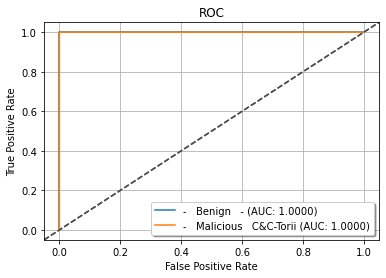

In [31]:
# Display ROC Curve

plcls.plot_roc(NB_evl, class_index=[0, 1], wait=True)

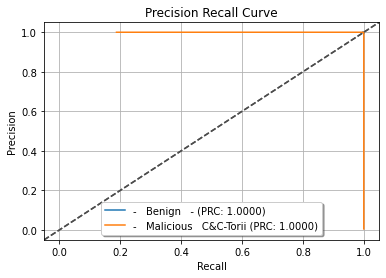

In [32]:
# Display Precision Recall Curve

plcls.plot_prc(NB_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

MLP Nueral Network

In [33]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.functions.MLPClassifier").to_help()) 

In [34]:
# Build and run MLP model

MLP_cls = Classifier(classname="weka.classifiers.functions.MLPClassifier")
MLP_cls.build_classifier(dataset)

MLP_evl = Evaluation(dataset)
MLP_evl.crossvalidate_model(MLP_cls, dataset, 10, Random(1))

print(MLP_evl.matrix("=== MLP Nueral Network ==="))
print(MLP_evl.summary())
print(MLP_evl.class_details())

=== MLP Nueral Network ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    1   15 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3207               99.9377 %
Incorrectly Classified Instances         2                0.0623 %
Kappa statistic                          0.9372
Mean absolute error                      0.012 
Root mean squared error                  0.0269
Relative absolute error                117.2834 %
Root relative squared error             38.1809 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.063    1.000      1.000    1.000      0.937    1.000     1.000     -   Benign   -
                 0.938    0.000    0.938      0.938    0.938      0.937    1.000     0.976     -   Malicious   C&C-Torii
Weighted Avg.    0.999    0.062    0.999      0.999    0.999    

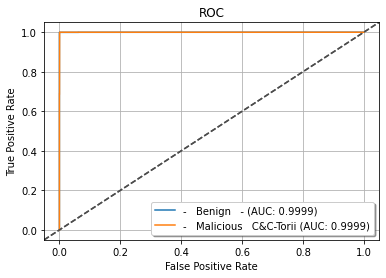

In [73]:
# Display ROC Curve

plcls.plot_roc(MLP_evl, class_index=[0, 1], wait=True)

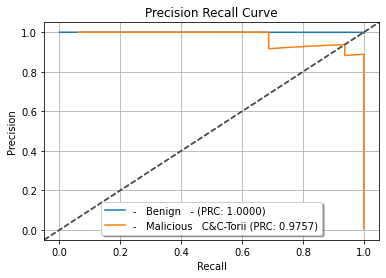

In [35]:
# Display Precision Recall Curve

plcls.plot_prc(MLP_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Stochastic Gradient Descent

In [36]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.functions.SGD").to_help()) 

In [37]:
# Build and run SGD model

SGD = Classifier(classname="weka.classifiers.functions.SGD")
SGD.build_classifier(dataset)

SGD_evl = Evaluation(dataset)
SGD_evl.crossvalidate_model(SGD, dataset, 10, Random(1))

print(SGD_evl.matrix("=== Stochastic Gradient Descent ==="))
print(SGD_evl.summary())
print(SGD_evl.class_details())

=== Stochastic Gradient Descent ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3207               99.9377 %
Incorrectly Classified Instances         2                0.0623 %
Kappa statistic                          0.9409
Mean absolute error                      0.0006
Root mean squared error                  0.025 
Relative absolute error                  6.0735 %
Root relative squared error             35.4414 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.999    0.000    1.000      0.999    1.000      0.943    1.000     1.000     -   Benign   -
                 1.000    0.001    0.889      1.000    0.941      0.943    1.000     0.889     -   Malicious   C&C-Torii
Weighted Avg.    0.999    0.000    0.999      0.999    

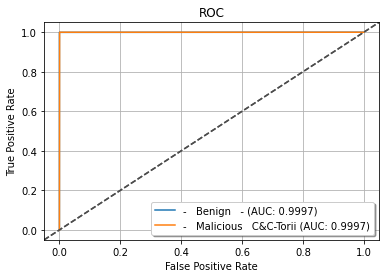

In [38]:
# Display ROC Curve

plcls.plot_roc(SGD_evl, class_index=[0, 1], wait=True)

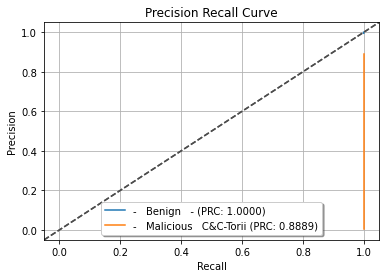

In [39]:
# Display Precision Recall Curve

plcls.plot_prc(SGD_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

KNN (K=1)

In [40]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.lazy.IBk").to_help()) 

In [41]:
# Build and run KNN model

IBk = Classifier(classname="weka.classifiers.lazy.IBk", options=["-K","1"])
IBk.build_classifier(dataset)

IBk_evl = Evaluation(dataset)
IBk_evl.crossvalidate_model(IBk, dataset, 10, Random(1))

print(IBk_evl.matrix("=== KNN (K=1) ==="))
print(IBk_evl.summary())
print(IBk_evl.class_details())

=== KNN (K=1) ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3208               99.9688 %
Incorrectly Classified Instances         1                0.0312 %
Kappa statistic                          0.9695
Mean absolute error                      0.0004
Root mean squared error                  0.0176
Relative absolute error                  4.1027 %
Root relative squared error             25.0536 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      0.970    1.000     1.000     -   Benign   -
                 1.000    0.000    0.941      1.000    0.970      0.970    1.000     0.945     -   Malicious   C&C-Torii
Weighted Avg.    1.000    0.000    1.000      1.000    1.000      0.970  

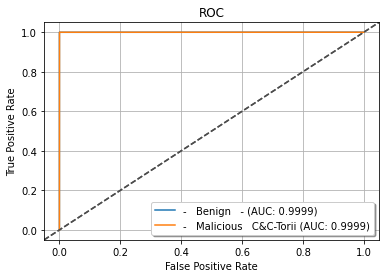

In [42]:
# Display ROC Curve

plcls.plot_roc(IBk_evl, class_index=[0, 1], wait=True)

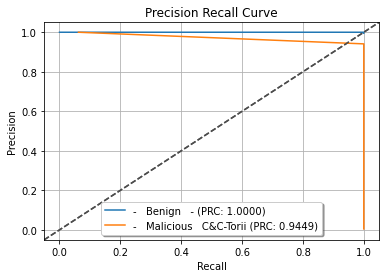

In [43]:
# Display Precision Recall Curve

plcls.plot_prc(IBk_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Voting Feature Intervals

In [44]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.misc.VFI").to_help())

In [45]:
# Build and run voting feature interval model

VFI = Classifier(classname="weka.classifiers.misc.VFI")
VFI.build_classifier(dataset)

VFI_evl = Evaluation(dataset)
VFI_evl.crossvalidate_model(VFI, dataset, 10, Random(1))

print(VFI_evl.matrix("=== Voting Feature Intervals ==="))
print(VFI_evl.summary())
print(VFI_evl.class_details())

=== Voting Feature Intervals ===
    a    b   <-- classified as
 3191    2 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3207               99.9377 %
Incorrectly Classified Instances         2                0.0623 %
Kappa statistic                          0.9409
Mean absolute error                      0.0006
Root mean squared error                  0.0232
Relative absolute error                  5.7234 %
Root relative squared error             32.9665 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.999    0.000    1.000      0.999    1.000      0.943    1.000     1.000     -   Benign   -
                 1.000    0.001    0.889      1.000    0.941      0.943    1.000     0.996     -   Malicious   C&C-Torii
Weighted Avg.    0.999    0.000    0.999      0.999    0.9

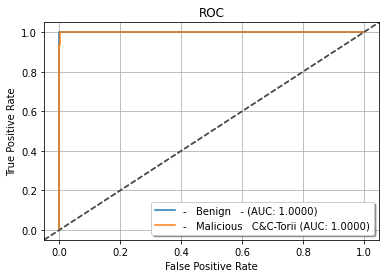

In [46]:
# Display ROC Curve

plcls.plot_roc(VFI_evl, class_index=[0, 1], wait=True)

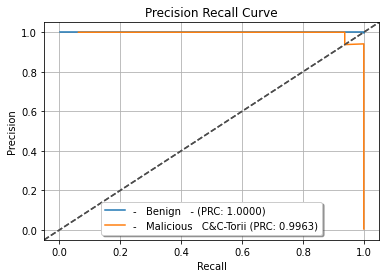

In [47]:
# Display Precision Recall Curve

plcls.plot_prc(VFI_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Sequential Minimal Optimization SVM

In [48]:
# Run to_help function to view algorithm description and options details

# print(Classifier(classname="weka.classifiers.functions.SMO").to_help())

In [49]:
# Build and run SMO SVM model

SMO = Classifier(classname="weka.classifiers.functions.SMO")
SMO.build_classifier(dataset)

SMO_evl = Evaluation(dataset)
SMO_evl.crossvalidate_model(SMO, dataset, 10, Random(1))

print(SMO_evl.matrix("=== Sequential Minimal Optimization SVM ==="))
print(SMO_evl.summary())
print(SMO_evl.class_details())

=== Sequential Minimal Optimization SVM ===
    a    b   <-- classified as
 3192    1 |    a = -   Benign   -
    0   16 |    b = -   Malicious   C&C-Torii


Correctly Classified Instances        3208               99.9688 %
Incorrectly Classified Instances         1                0.0312 %
Kappa statistic                          0.9695
Mean absolute error                      0.0003
Root mean squared error                  0.0177
Relative absolute error                  3.0367 %
Root relative squared error             25.0609 %
Total Number of Instances             3209     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    0.000    1.000      1.000    1.000      0.970    1.000     1.000     -   Benign   -
                 1.000    0.000    0.941      1.000    0.970      0.970    1.000     0.941     -   Malicious   C&C-Torii
Weighted Avg.    1.000    0.000    1.000      1

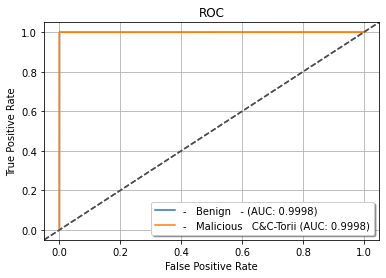

In [50]:
# Display ROC Curve

plcls.plot_roc(SMO_evl, class_index=[0, 1], wait=True)

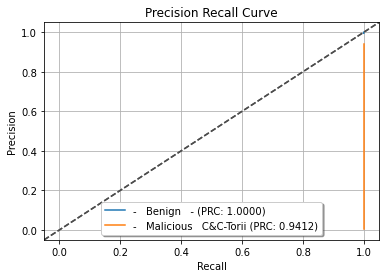

In [51]:
# Display Precision Recall Curve

plcls.plot_prc(SMO_evl, title="Precision Recall Curve", class_index=[0,1], wait=True)

Stop Java VM

In [3]:
# Stop JVM. May need to restart compute cluster or jupyter kernal if jvm restart is required.

jvm.stop()